# Camera Calibration and 3D Reconstruction

> see: https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#fisheye  
> see: https://www.mathworks.com/help/vision/ug/camera-calibration.html  
> see: https://www.mathworks.com/help/vision/ug/fisheye-calibration-basics.html  

## 1. Pinhole Camera Model

The functions in this section use a so-called pinhole camera model. In this model, a scene view is formed by projecting 3D points into the image plane using a perspective transformation.

$$
\lambda p =K [R \mid t] P
$$

or 

$$
\lambda \left[\begin{array}{l}
u \\
v \\
1
\end{array}\right]=\left[\begin{array}{ccc}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{array}\right]\left[\begin{array}{llll}
r_{11} & r_{12} & r_{13} & t_1 \\
r_{21} & r_{22} & r_{23} & t_2 \\
r_{31} & r_{32} & r_{33} & t_3
\end{array}\right]\left[\begin{array}{l}
X \\
Y \\
Z \\
1
\end{array}\right]
$$

where:

- $(X, Y, Z)$ are the coordinates of a 3D point in the world coordinate space
- $(u, v)$ are the coordinates of the projection point in pixels
- $K$ is a camera matrix, or a matrix of intrinsic parameters
- $R$ and $t$: rotation matrix and translation vector
- $(c_x, c_y)$ is a principal point that is usually at the image center
- $f_x$, $f_y$ are the focal lengths expressed in pixel units.

Thus, if an image from the camera is scaled by a factor, all of these parameters should be scaled (multiplied/divided, respectively) by the same factor. The matrix of intrinsic parameters does not depend on the scene viewed. So, once estimated, it can be re-used as long as the focal length is fixed (in case of zoom lens). The joint rotation-translation matrix $[R \mid t]$ is called a matrix of extrinsic parameters. It is used to describe the camera motion around a static scene, or vice versa, rigid motion of an object in front of a still camera. That is, $[R \mid t]$ translates coordinates of a point $(X, Y, Z)$ to a coordinate system, fixed with respect to the camera. The transformation above is equivalent to the following (when $z \ne 0$ ):

$$\begin{aligned}
&{\left[\begin{array}{l}
x \\
y \\
z
\end{array}\right]=R\left[\begin{array}{l}
X \\
Y \\
Z
\end{array}\right]+t} \\
&x^{\prime}=x / z \\
&y^{\prime}=y / z \\
&u=f_x * x^{\prime}+c_x \\
&v=f_y * y^{\prime}+c_y
\end{aligned}
$$

The following figures illustrates the pinhole camera model.

<p align="center">
  <img src="./files/pinhole_camera_model.png" alt="drawing" width="600"/>
</p>

Or see this figure for Pinhole Camera Model introduced in Matlab Document.

<p align="center">
  <img src="./files/camera-calibration-focal-point.svg" alt="drawing" width="600"/>
</p>

and 

<p align="center">
  <img src="./files/calibration-cameramodel-coords-outline.svg" alt="drawing" width="600"/>
</p>

The camera matrix does not account for lens distortion because an ideal pinhole camera does not have a lens. To accurately represent a real camera, the camera model includes the radial and tangential lens distortion.

Real lenses usually have some distortion, mostly radial distortion and slight tangential distortion. So, the above model is extended as:

$$
\begin{aligned}
&\begin{aligned}
&{\left[\begin{array}{l}
x \\
y \\
z
\end{array}\right]=R\left[\begin{array}{l}
X \\
Y \\
Z
\end{array}\right]+t} \\
&x^{\prime}=x / z
\end{aligned}\\
&y^{\prime}=y / z\\
&x^{\prime \prime}=x^{\prime} \frac{1+k_1 r^2+k_2 r^4+k_3 r^6}{1+k_4 r^2+k_5 r^{r^4}+k_{\sigma^6} r^6}+2 p_1 x^{\prime} y^{\prime}+p_2\left(r^2+2 x^{\prime 2}\right)\\
&y^{\prime \prime}=y^{\prime} \frac{1+k_1 r^2+k_2 r^4+k_3 r^6}{1+k_4 r^2+k_5 r^{\prime}+k_6 r^{\prime}}+p_1\left(r^2+2 y^{\prime 2}\right)+2 p_2 x^{\prime} y^{\prime}\\
&\text { where } r^2=x^{\prime 2}+y^{\prime 2}\\
&u=f_x * x^{\prime \prime}+c_x\\
&v=f_y * y^{\prime \prime}+c_y
\end{aligned}
$$

$k_1$, $k_2$, $k_3$, $k_4$, $k_5$ and $k_6$ are `radial distortion` coefficients. $p_1$ and $p_2$ are `tangential distortion` coefficients. Higher-order coefficients are not considered in OpenCV.

### Radial Distortion
The next figure shows two common types of **radial distortion**: 
- barrel distortion (typically $k_1$ > 0 and 
- pincushion distortion (typically $k_1$ < 0).

<p align="center">
  <img src="./files/distortion_examples.png" alt="drawing" width="600"/>
</p>

### Tangential Distortion

Tangential distortion occurs when the lens and the image plane are not parallel. The tangential distortion coefficients model this type of distortion.

<p align="center">
  <img src="./files/calibration_tangential_distortion.png" alt="drawing" width="600"/>
</p>

In the functions below the coefficients are passed or returned as

$(k_1, k_2, p_1, p_2[, k_3[, k_4, k_5, k_6]])$

vector. That is, if the vector contains **four** elements, it means that $k_3=0$. The distortion coefficients do not depend on the scene viewed. Thus, they also belong to the intrinsic camera parameters. And they remain the same regardless of the captured image resolution. If, for example, a camera has been calibrated on images of $320 \times 240$ resolution, absolutely the same distortion coefficients can be used for $640 \times 480$ images from the same camera while $f_x$, $f_y$, $c_x$, and $c_y$ need to be scaled appropriately.

The functions below use the above model to do the following:

- Project 3D points to the image plane given intrinsic and extrinsic parameters.
- Compute extrinsic parameters given intrinsic parameters, a few 3D points, and their projections.
- Estimate intrinsic and extrinsic camera parameters from several views of a known calibration pattern (every view is described by several 3D-2D point correspondences).
- Estimate the relative position and orientation of the stereo camera `heads` and compute the rectification transformation that makes the camera optical axes parallel.

## 2. Function cv2.calibrateCamera()

- It finds the camera intrinsic and extrinsic parameters from several views of a calibration pattern.

- The algorithm is based on [Zhang2000] and [BouguetMCT]. The coordinates of 3D object points and their corresponding 2D projections in each view must be specified. That may be achieved by using an object with a known geometry and easily detectable feature points. Such an object is called a `calibration rig` or `calibration pattern`, and OpenCV has built-in support for a chessboard as a calibration rig (see [findChessboardCorners()](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#bool%20findChessboardCorners(InputArray%20image,%20Size%20patternSize,%20OutputArray%20corners,%20int%20flags)) ). Currently, initialization of intrinsic parameters (when `CV_CALIB_USE_INTRINSIC_GUESS` is not set) is only implemented for planar calibration patterns (where Z-coordinates of the object points must be all zeros). 3D calibration rigs can also be used as long as initial cameraMatrix is provided.

- The algorithm performs the following steps:

  - Compute the initial intrinsic parameters (the option only available for planar calibration patterns) or read them from the input parameters. The distortion coefficients are all set to zeros initially unless some of CV_CALIB_FIX_K? are specified.
  - Estimate the initial camera pose as if the intrinsic parameters have been already known. This is done using [solvePnP()](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#bool%20solvePnP(InputArray%20objectPoints,%20InputArray%20imagePoints,%20InputArray%20cameraMatrix,%20InputArray%20distCoeffs,%20OutputArray%20rvec,%20OutputArray%20tvec,%20bool%20useExtrinsicGuess,%20int%20flags)), which finds an object pose from 3D-2D point correspondences (note: PnP means Perspective-n-Point for camera pose estimation).
  - Run the global `Levenberg-Marquardt` optimization algorithm to minimize the `reprojection error`, that is, the total sum of squared distances between the observed feature points imagePoints and the projected (using the current estimates for camera parameters and the poses) object points objectPoints. See [projectPoints()](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#void%20projectPoints(InputArray%20objectPoints,%20InputArray%20rvec,%20InputArray%20tvec,%20InputArray%20cameraMatrix,%20InputArray%20distCoeffs,%20OutputArray%20imagePoints,%20OutputArray%20jacobian,%20double%20aspectRatio)) for details.
  
- The function returns the final re-projection error.

## 3. An Example of Camera Calibration for Distorted Images with Chessboard Samples

> see code at https://github.com/opencv/opencv/blob/master/samples/python/calibrate.py

Here we run a [python code](https://github.com/opencv/opencv/blob/master/samples/python/calibrate.py) for camera calibration for distorted images with chess board samples. Given distorted images, it calculates the calibration and write undistorted images. 

In [29]:
'''
camera calibration for distorted images with chess board samples
reads distorted images, calculates the calibration and write undistorted images
'''
import matplotlib.pyplot as plt
import numpy as np
import cv2

# local modules

# built-in modules
import os
import sys

def splitfn(fn):
    path, fn = os.path.split(fn)
    name, ext = os.path.splitext(fn)
    return path, name, ext

def run_calibrate(img_names, debug_dir = 'results/debug'):

    if debug_dir and not os.path.isdir(debug_dir):
        os.mkdir(debug_dir)
    
    square_size = 1.0
    threads_num = 4


    pattern_size = (9, 6)
    pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
    pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
    pattern_points *= square_size

    obj_points = []
    img_points = []
    # TODO: use imquery call to retrieve results
    h, w = cv2.imread(img_names[0], cv2.IMREAD_GRAYSCALE).shape[:2]

    def processImage(fn):
        print('processing %s... ' % fn)
        img = cv2.imread(fn, 0)
        if img is None:
            print("Failed to load", fn)
            return None

        assert w == img.shape[1] and h == img.shape[0], ("size: %d x %d ... " % (img.shape[1], img.shape[0]))
        found, corners = cv2.findChessboardCorners(img, pattern_size)
        if found:
            term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
            cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

        if debug_dir:
            vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            cv2.drawChessboardCorners(vis, pattern_size, corners, found)
            _path, name, _ext = splitfn(fn)
            outfile = os.path.join(debug_dir, name + '_chess.png')
            cv2.imwrite(outfile, vis)

        if not found:
            print('chessboard not found')
            return None

        print('           %s... OK' % fn)
        return (corners.reshape(-1, 2), pattern_points)

    if threads_num <= 1:
        chessboards = [processImage(fn) for fn in img_names]
    else:
        print("Run with %d threads..." % threads_num)
        from multiprocessing.dummy import Pool as ThreadPool
        pool = ThreadPool(threads_num)
        chessboards = pool.map(processImage, img_names)

    chessboards = [x for x in chessboards if x is not None]
    for (corners, pattern_points) in chessboards:
        img_points.append(corners)
        obj_points.append(pattern_points)

    # calculate camera distortion
    rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(
        obj_points, 
        img_points, (w, h), None, None)

    print("\nRMS:", rms)
    print("camera matrix:\n", camera_matrix)
    print("distortion coefficients: ", dist_coefs.ravel())

    # undistort the image with the calibration
    print('')
    for fn in img_names if debug_dir else []:
        _path, name, _ext = splitfn(fn)
        img_found = os.path.join(debug_dir, name + '_chess.png')
        outfile = os.path.join(debug_dir, name + '_undistorted.png')

        img = cv2.imread(img_found)
        if img is None:
            continue

        h, w = img.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(
            camera_matrix, dist_coefs, (w, h), 1, (w, h))

        dst = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

        # crop and save the image
        x, y, w, h = roi
        dst_roi= dst[y:y+h, x:x+w]
        # Draw the rectified images
        
        if fn.endswith("left12.jpg"):
            fig, axes = plt.subplots(1, 3, figsize=(15, 10))
            #fig, axes = plt.subplots(1, 3)
            axes[0].imshow(img)
            axes[1].imshow(dst)
            axes[2].imshow(dst_roi)
            axes[0].title.set_text("Input Distorted Image")
            axes[1].title.set_text("Undistorted Image")
            axes[2].title.set_text("Undistorted Image with ROI")
            plt.suptitle("Camera Calibration and Image Undistortion")
            plt.show()

        print('Undistorted image written to: %s' % outfile)
        cv2.imwrite(outfile, dst_roi)

    print('Done')

Now let run it using 14 images `left01.jpg, ..., ;eft14.jpg` saved at `./data`. 


camera calibration for distorted images with chess board samples
reads distorted images, calculates the calibration and write undistorted images

Run with 4 threads...
processing ./data/left01.jpg... 
processing ./data/left02.jpg... 
processing ./data/left03.jpg... 
processing ./data/left04.jpg... 
           ./data/left01.jpg... OK
processing ./data/left05.jpg... 
           ./data/left03.jpg... OK
processing ./data/left06.jpg... 
           ./data/left04.jpg... OK
processing ./data/left07.jpg... 
           ./data/left05.jpg... OK
processing ./data/left08.jpg... 
           ./data/left07.jpg... OK
processing ./data/left09.jpg... 
           ./data/left02.jpg... OK
processing ./data/left11.jpg... 
           ./data/left08.jpg... OK
processing ./data/left12.jpg... 
           ./data/left12.jpg... OK
processing ./data/left13.jpg... 
           ./data/left06.jpg... OK
processing ./data/left14.jpg... 
           ./data/left09.jpg... OK
           ./data/left13.jpg... OK
           ./data

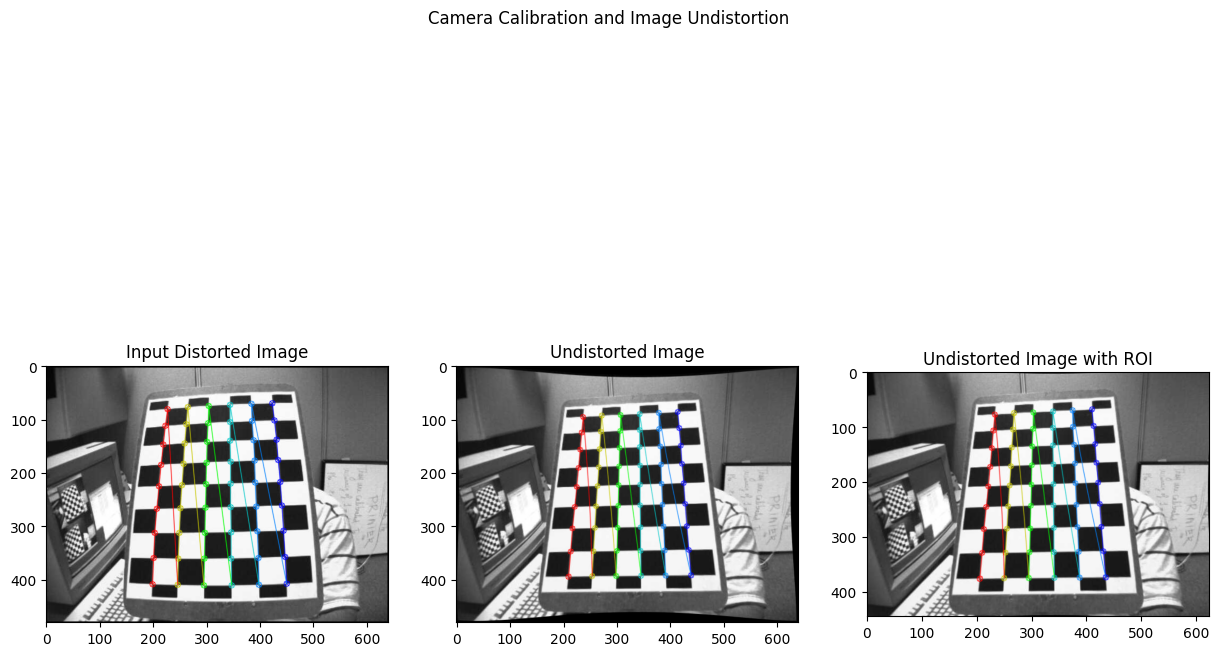

Undistorted image written to: results/debug/left12_undistorted.png
Undistorted image written to: results/debug/left13_undistorted.png
Undistorted image written to: results/debug/left14_undistorted.png
Done


In [30]:
print(__doc__)
img_names = [f'./data/left{n:02d}.jpg' for n in range(1, 15) if n != 10]
run_calibrate(img_names, debug_dir = 'results/debug')
#cv.destroyAllWindows()

## 5. Fisheye Calibration Basics

Camera calibration is the process of computing the extrinsic and intrinsic parameters of a camera. Once you calibrate a camera, you can use the image information to recover 3-D information from 2-D images. You can also `undistort images` taken with a fisheye camera. The Computer Vision Toolbox™ contains calibration algorithms for the pinhole camera model and the fisheye camera model. You can use the fisheye model with cameras up to a `field of view (FOV)` of 195 degrees.

<p align="center">
  <img src="./files/pinhole-fisheye.svg" alt="drawing" width="600"/>
</p>


Fisheye cameras are used in odometry and to solve the simultaneous localization and mapping (SLAM) problems visually. Other applications include, surveillance systems, GoPro, virtual reality (VR) to capture 360 degree field of view (fov), and stitching algorithms. These cameras use a complex series of lenses to enlarge the camera's field of view, enabling it to capture wide panoramic or hemispherical images. However, the lenses achieve this extremely wide angle view by distorting the lines of perspective in the images.

<p align="center">
  <img src="./files/beforeafter_fisheye.png" alt="drawing" width="600"/>
</p>

Because of the extreme distortion a fisheye lens produces, the pinhole model cannot model a fisheye camera.

For the fisheye camera model, the `intrinsic` parameters include the polynomial mapping coefficients of the projection function. The `alignment coefficients` are related to sensor alignment and the transformation from the sensor plane to a pixel location in the camera image plane.

The $P= (X, Y, Z)$ be a point in 3D in the world reference frame. The coordinate vector of P in the camera reference frame is $(x, y, x)$ and the coordinate vector of P in the image frame is $(u,v)$:

$$
\begin{aligned}
&\begin{aligned}
&{\left[\begin{array}{l}
x \\
y \\
z
\end{array}\right]=R\left[\begin{array}{l}
X \\
Y \\
Z
\end{array}\right]+t} \\
&x^{\prime}=x / z
\end{aligned}\\
&y^{\prime}=y / z\\
&x^{\prime \prime}=x^{\prime} (\theta_d/r)\\
&y^{\prime \prime}=y^{\prime} (\theta_d/r) \\
&\text { where } r^2=x^{\prime 2}+y^{\prime 2} \\
& \theta = atan(r) \\
& \theta_d = \theta (1 + k_1 \theta^2 + k_2 \theta^4 + k_3 \theta^6 + k_4 \theta^8) \\
&u=f_x * (x^{\prime \prime} + \alpha y^{\prime \prime})+c_x\\
&v=f_y * y^{\prime \prime}+c_y
\end{aligned}
$$

where
- $(X, Y, Z)$ are the coordinates of a 3D point in the world coordinate space
- $(u, v)$ are the coordinates of the projection point in pixels
- $R$ and $t$: rotation matrix and translation vector
- $(c_x, c_y)$ is a principal point that is usually at the image center
- $\alpha$: the skew coefficient (default = 0).
- $k_1$, $k_2$, $k_3$, $k_4$ are distortion coefficients.
- $f_x$, $f_y$ are the focal lengths expressed in pixel units.

Summary: Generic camera model (see paper: Juho Kannala and Sami Brandt. A generic camera model and calibration method for conventional, wide-angle, and fish-eye lenses. IEEE transactions on pattern analysis and machine intelligence, 28:1335–40, 09 2006.) with perspective projection and without distortion correction.

## 6. Function cv::fisheye::calibrate
> see the blog: https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0  

When you are using a fisheye (>160 degree field-of-view) lens, the `classic` way in OpenCV to calibrate lens may not work for you. Even if you carefully follow steps in OpenCV document, you may end up with ‘undistorted’ images like these:

<p align="center">
  <img src="./files/1_cLlGbhbZVlQGMwHeS9m__w.png" alt="drawing" width="600"/>
</p>

cv2.fisheye.calibrate() will calibrate the fisheye lens with 2 main steps.

- Find parameters K and D, where K is intrinsic and D is distortion matrix.
- Un-distort images by applying K and D.

Now let us find the K and D first.

In [98]:
# > see: https://docs.nvidia.com/vpi/sample_fisheye.html
def run_fisheye_calibrate(img_names, is_display= False):
    assert cv2.__version__[0] >= '3', 'The fisheye module requires opencv version >= 3.0.0'
    
    # Search window width around checkerboard verted used in refinement, 
    # default is 0 (disable refinement)
    sub_s = 3
    
    #Checkerboard with WxH squares
    cbSize = np.array([5,7])
    # =========================================
    # Calculate fisheye calibration from images
    
    # OpenCV expects number of interior vertices in the checkerboard,
    # not number of squares. Let's adjust for that.
    vtxCount = cbSize-1
    
    # -------------------------------------------------
    # Determine checkerboard coordinates in image space
    
    imgSize = None
    corners2D = []
    
    for idx, imgName in enumerate(img_names):
        # Load input image and do some sanity check
        img = cv2.imread(imgName)
        curImgSize = (img.shape[1], img.shape[0])
    
        if imgSize == None:
            imgSize = curImgSize
        elif imgSize != curImgSize:
            exit("All images must have the same size")
    
        # Find the checkerboard pattern on the image, saving the 2D
        # coordinates of checkerboard vertices in cbVertices.
        # Vertex is the point where 4 squares (2 white and 2 black) meet.
        found, corners = cv2.findChessboardCorners(img, tuple(vtxCount), 
                            flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE)
        if found:
            # Needs to perform further corner refinement?
            if sub_s != None and sub_s >= 2:
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.0001)
                imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                corners = cv2.cornerSubPix(imgGray, corners, (sub_s//2, sub_s//2), (-1,-1), criteria)
            corners2D.append(corners)
            if is_display and idx == 3:
                vis = img
                cv2.drawChessboardCorners(vis, vtxCount, corners, found)
                _path, name, _ext = splitfn(imgName)
                #outfile = os.path.join('/home/ccj/code/studynotes/stereo-matching/results', name + '_chess.png')
                #cv2.imwrite(outfile, vis)
                plt.title(f"Chessborad Corners img-{idx}", loc='center')
                plt.imshow(vis)
                plt.show()
        else:
            exit("Warning: checkerboard pattern not found in image {}".format(input))
    
    # Create the vector that stores 3D coordinates for each checkerboard pattern on a space
    # where X and Y are orthogonal and run along the checkerboard sides, and Z==0 in all points on
    # checkerboard.
    cbCorners = np.zeros((1, vtxCount[0]*vtxCount[1], 3))
    cbCorners[0,:,:2] = np.mgrid[0:vtxCount[0], 0:vtxCount[1]].T.reshape(-1,2)
    square_size = 1.0
    cbCorners *= square_size
    corners3D = [cbCorners.reshape(-1,1,3) for i in range(len(corners2D))]
    
    # ---------------------------------------------
    # Calculate fisheye lens calibration parameters
    ## flags_0 does not work;
    calibration_flags_0 = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
    calibration_flags_1 = cv2.fisheye.CALIB_FIX_SKEW
    calibration_flags_2 = cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
    camMatrix = np.eye(3)
    coeffs = np.zeros((4,))
    rms, camMatrix, coeffs, rvecs, tvecs = cv2.fisheye.calibrate(
                corners3D, 
                corners2D, 
                imgSize, 
                camMatrix, 
                coeffs,
                #flags=calibration_flags_1,
                flags=calibration_flags_2
    )
    
    # Print out calibration results
    print("rms error: {}".format(rms))
    print("Fisheye distortion coefficients: {}".format(coeffs))
    print("Camera matrix: \n", camMatrix)
    w, h = imgSize
    return camMatrix, coeffs, h, w

- Now let us estimate the intrinsic K and distorction coefficients D.

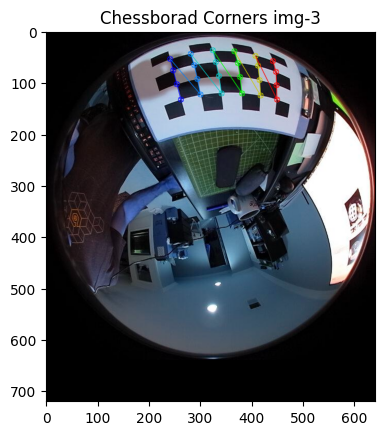

rms error: 56.86035005533988
Fisheye distortion coefficients: [-0.07923483  0.30452622 -0.36872569  0.07582416]
Camera matrix: 
 [[211.07208004   0.         319.72780467]
 [  0.         211.42678264 358.42366927]
 [  0.           0.           1.        ]]
find K and D done


In [95]:
img_names = [f'./data/calibration/fisheye/chessboard/{n:d}.jpg' for n in range(1, 27)]
K, D, h, w = run_fisheye_calibrate(img_names, is_display= True)
print ("find K and D done")

## 7. Function cv2.fisheye.initUndistortRectifyMap() undistort given the K and D

Give the the intrinsic matrix K and distortion coefficients D, we can apply function cv2.fisheye.initUndistortRectifyMap() to do undistortion. Please know that K and D can be:
- estimated by yourself using function cv::fisheye::calibrate() as above, or
- pulic datasets usually provide K and D, which we can directly use for undistortion.

In [101]:
def run_fisheye_undistort(K, D, img_path, DIM=None, is_display=False):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    if DIM is None:
        DIM =  (w, h)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        K, D, np.eye(3), K, DIM, 
        cv2.CV_16SC2 #Type of the first output map
        )
    
    undistorted_img = cv2.remap(img, map1, map2, 
                    interpolation=cv2.INTER_LINEAR, 
                    borderMode=cv2.BORDER_CONSTANT)
    img_fn, img_ext = img_path.split('/')[-1].split('.')
    _path, name, _ext = splitfn(img_path)
    
    tmp_fn = "./results/" + name + '_undistorted' + _ext
    cv2.imwrite(tmp_fn, undistorted_img)
    print (f"Saved {tmp_fn}")
    
    if is_display:
        # Draw the rectified images
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        axes[0].imshow(img)
        axes[1].imshow(undistorted_img)
        axes[0].title.set_text("Fisheye Image")
        axes[1].title.set_text("Undistortion Image")

        plt.suptitle("Input Image img-{}".format(name))
        
        #plt.savefig(tmp_fn)    
        plt.show()

Saved ./results/1_undistorted.jpg
Saved ./results/2_undistorted.jpg
Saved ./results/3_undistorted.jpg
Saved ./results/4_undistorted.jpg
Saved ./results/5_undistorted.jpg
Saved ./results/6_undistorted.jpg
Saved ./results/7_undistorted.jpg
Saved ./results/8_undistorted.jpg
Saved ./results/9_undistorted.jpg


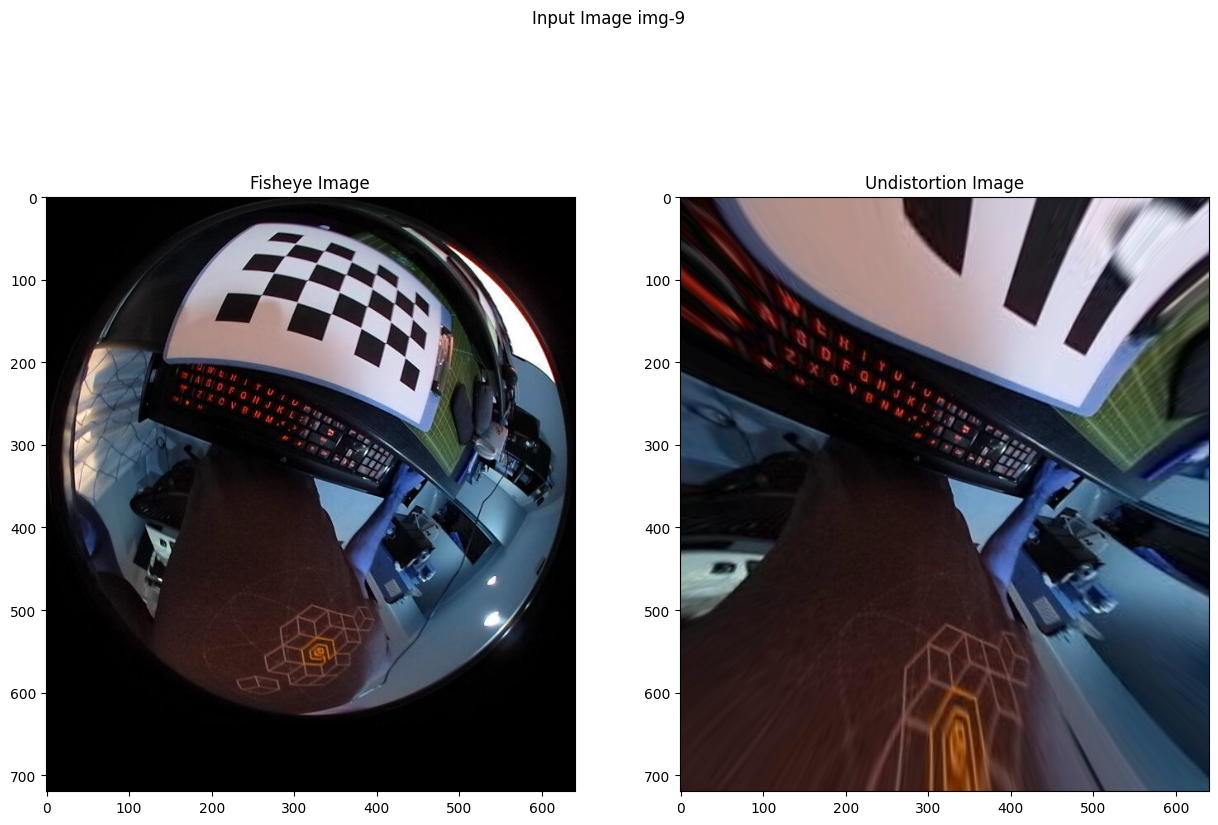

Saved ./results/10_undistorted.jpg
Saved ./results/11_undistorted.jpg
Saved ./results/12_undistorted.jpg
Saved ./results/13_undistorted.jpg
Saved ./results/14_undistorted.jpg
Saved ./results/15_undistorted.jpg
Saved ./results/16_undistorted.jpg


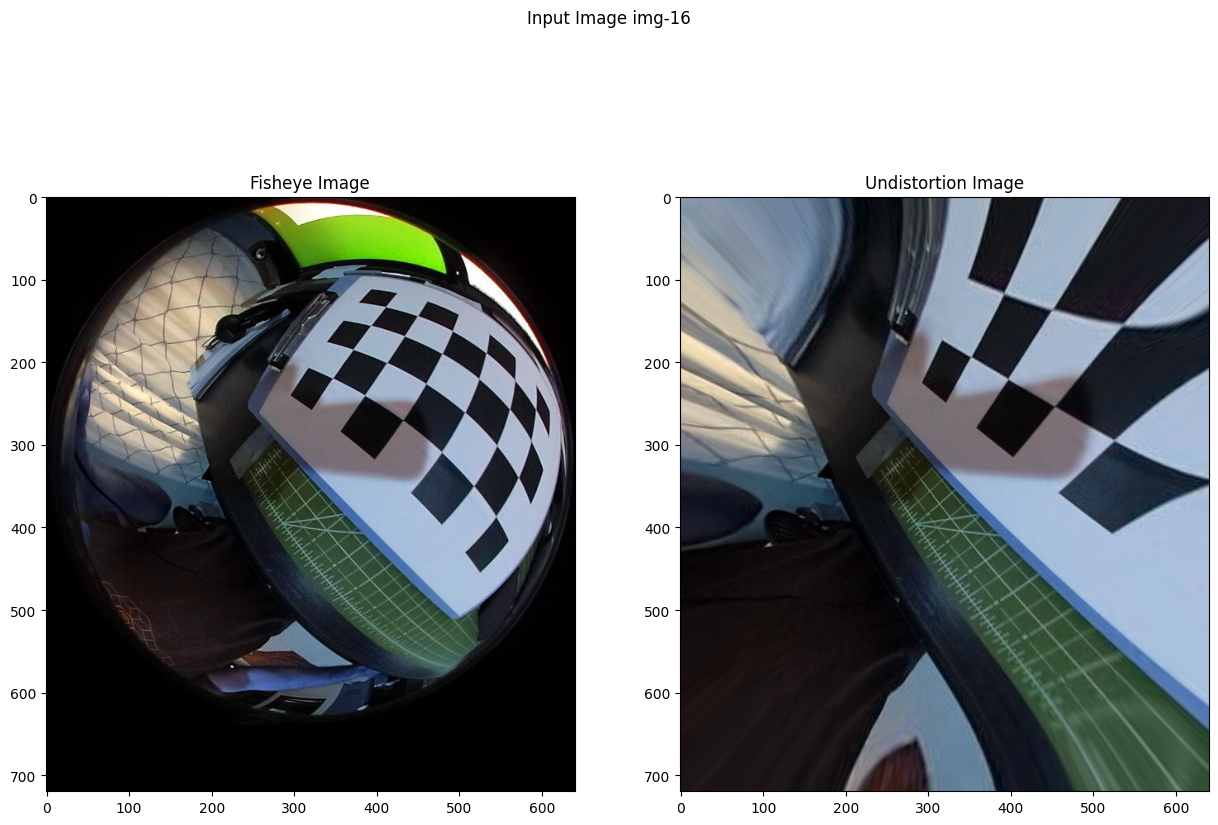

Saved ./results/17_undistorted.jpg
Saved ./results/18_undistorted.jpg
Saved ./results/19_undistorted.jpg
Saved ./results/20_undistorted.jpg
Saved ./results/21_undistorted.jpg
Saved ./results/22_undistorted.jpg
Saved ./results/23_undistorted.jpg
Saved ./results/24_undistorted.jpg
Saved ./results/25_undistorted.jpg
Saved ./results/26_undistorted.jpg


In [102]:
for idx, fn in enumerate(img_names):
    run_fisheye_undistort(K, D, fn, DIM = (w, h), is_display = (idx == 8 or idx == 15))

Let us try other fisheye images with known K and D. Let us try one image from EuRoC dataset (`EuRoC/MH01/mav0/cam0/data/1403636579763555584.png`).

Saved ./results/euroc_mh1_cam1_1403636579763555584_undistorted.png


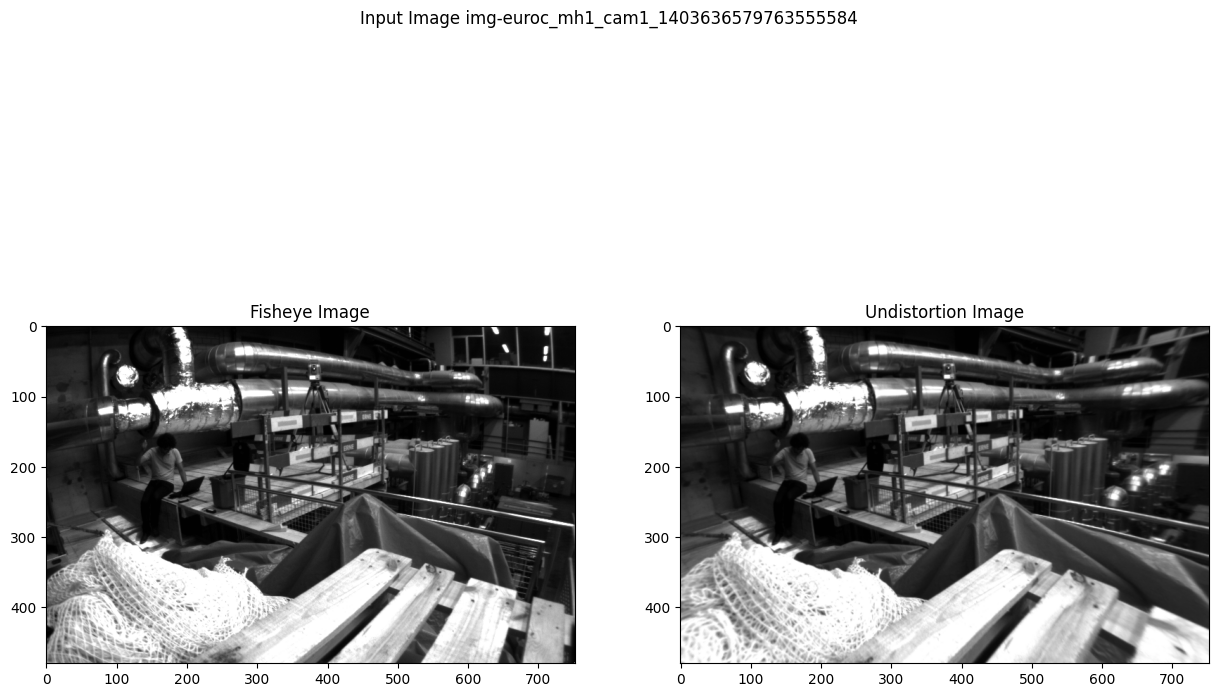

In [103]:
img_fn = './data/euroc_mh1_cam1_1403636579763555584.png'
K_left = np.array([
            [233.5815582275391, 0, 313.1435241699219],
            [0, 233.7541656494141, 195.3465576171875],
            [0, 0, 1]], dtype=np.float32)
D_left = np.array(
            [0.1519210785627365, 0.9335227012634277, -1.079947352409363, 0.3326298892498016],
            dtype=np.float32)

run_fisheye_undistort(K_left, D_left, img_fn, DIM = None, is_display = True)